In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.cross_validation import StratifiedKFold,KFold,train_test_split
from scipy.stats import randint, uniform
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import LabelKFold
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt

import datetime
import random
from operator import itemgetter
import time
import copy

from scipy.io import mmread

np.random.seed(333)

In [2]:
dtrain = (mmread('writemm_sparse_grp1/dtrain_sparse_grp1')).tocsr()
dtest = (mmread('writemm_sparse_grp1/dtest_sparse_grp1')).tocsr()

act_train_data = pd.read_csv("redhat_data_new/act_train_new_try2.csv",dtype={'people_id': np.str, 'activity_id': np.str, 'outcome': np.int8}, parse_dates=['date'])
act_test_data  = pd.read_csv("redhat_data_new/act_test_new_try2.csv", dtype={'people_id': np.str, 'activity_id': np.str}, parse_dates=['date'])
people_data    = pd.read_csv("redhat_data_new/people.csv", dtype={'people_id': np.str, 'activity_id': np.str, 'char_38': np.int32}, parse_dates=['date'])

In [3]:
act_test_data['outcome'] = pd.Series([0.5]*(act_test_data.shape[0]))
train_data = pd.concat([act_train_data, act_test_data], ignore_index=True)
print('All features: train_data shape {}'.format(train_data.shape))

All features: train_data shape (2695978, 15)


In [4]:
from scipy.sparse import csr_matrix, hstack, vstack
Xtrain = vstack((dtrain, dtest), format='csr')
print('All features: train shape {}'.format(Xtrain.shape))

All features: train shape (2695978, 332)


In [5]:
y1 = [0]*(dtrain.shape[0])
y2 = [1]*(dtest.shape[0])
y = pd.Series(y1 + y2)
from sklearn.preprocessing import LabelEncoder
targetencoder = LabelEncoder().fit(y.values)
y = targetencoder.transform(y.values)
nclasses = len(targetencoder.classes_)

In [6]:
from sklearn import preprocessing
max_abs_scaler = preprocessing.MaxAbsScaler()
Xtrain = max_abs_scaler.fit_transform(Xtrain)

In [7]:
lkf = LabelKFold(train_data['people_id'], n_folds=5)
def score(clf, random_state = 444):
    #lkf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in lkf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        print("{:.5f}".format(roc_auc_score(yte, pred[itest,1:])), end=' ')
        return roc_auc_score(yte, pred[itest, 1:])
    
    print("score : {:.5f}".format(roc_auc_score(y, pred[:,1:])), end=' ')
    return pred

[  1.00000000e-05   1.27427499e-05   1.62377674e-05   2.06913808e-05
   2.63665090e-05   3.35981829e-05   4.28133240e-05   5.45559478e-05
   6.95192796e-05   8.85866790e-05   1.12883789e-04   1.43844989e-04
   1.83298071e-04   2.33572147e-04   2.97635144e-04   3.79269019e-04
   4.83293024e-04   6.15848211e-04   7.84759970e-04   1.00000000e-03]
0.77887 0.78035 0.78167 0.78292 0.78410 0.78522 0.78617 0.78720 0.78815 0.78895 0.78967 0.79030 0.79085 0.79127 0.79157 0.79172 0.79188 0.79179 0.79179 0.79183 

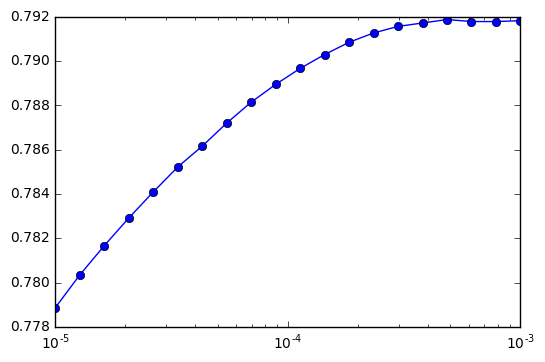

In [10]:
Cs = np.logspace(-5,-3,20)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C=C, class_weight='balanced', solver='lbfgs', n_jobs=-1)))
plt.semilogx(Cs, res,'-o');

In [ ]:
preds = score(LogisticRegression(C=9.40444852, class_weight='balanced', solver='lbfgs', n_jobs=-1))